## 1. Importing libraries

In [22]:
from docarray import Document, DocumentArray

## 2. Configuration and setup

We'll set up some basic variables. Feel free to adapt these for your own project!

In [75]:
MAX_DOCS = 10000
DATA_DIR = 'data/images'
DATA_PATH = f"{DATA_DIR}/*/*.jpg"
QUERY_IMAGE = "data/query.jpg"

Now we initiate the vector storage of the images, using Weaviate. You'll need to have a Weaviate instance running on `http://localhost:8080`. You can do that by running `docker compose up` in the terminal in this folder, using the `docker-compose.yml` file. 

In [76]:
da = DocumentArray(storage='weaviate', config={'host': 'localhost', 'port': '8080', 'name': 'Image'})

da.summary()

       Documents Summary        
                                
  Length                 0      
  Homogenous Documents   False  
                                
              Storage Summary              
                                           
  Backend                  Weaviate        
  Host                     localhost       
  Port                     8080            
  Protocol                 http            
  Schema Name              Eacadebeccacde  
  Serialization Protocol

## 3. Load Data

Now that all is set up, we can start adding the fashion images to the database. 

In [77]:
docs = da.from_files(DATA_PATH, size=MAX_DOCS, storage='weaviate', config={'host': 'localhost', 'port': '8080', 'name': 'image'})
print(f"{len(docs)} Documents in DocumentArray")

10000 Documents in DocumentArray


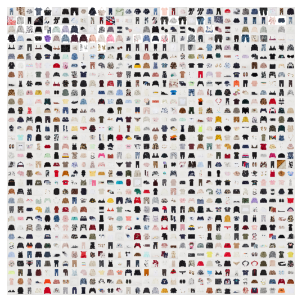

In [78]:
docs.plot_image_sprites() # Preview the images

## 4. Preprocess Data

In [79]:
# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [80]:
# apply en masse
docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 10000                                 
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       10000            False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   10000            False            
  uri         ('str',)       10000            False            
                                                               
            Storage Summary            
                                       
  Backend                  Weaviate    
  Host                     localhost   
  Port                     8080        
  Protocol                 http        
  Schema Name              Fcbeccacde  
  Serialization Protocol

## 5. Embed images

In [81]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [82]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

In [83]:
docs.embed(model, device=device)

KeyError: '01b6de6b-99d2-5eb8-84c9-3528ae4bba14'

ReadTimeout: HTTPConnectionPool(host='localhost', port=8080): Read timed out. (read timeout=20)

## 6. Query dataset

Let's query the dataset with one of the images of the dataset. We've stored this in `data/query.jpg`. Feel free to choose any jpg image of clothing as query image.

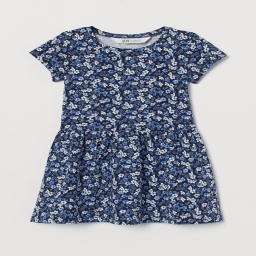

In [84]:
query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()

In [85]:
query_docs = DocumentArray([query_doc])

In [86]:
query_docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 1                                     
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   1                False            
  uri         ('str',)       1                False

In [87]:
query_docs.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

                             Documents Summary                              
                                                                            
  Length                 1                                                  
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    1                False            
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   1                False            
  uri         ('str',)       1                False

In [90]:
query_docs.match(docs, limit=9)

ReadTimeout: HTTPConnectionPool(host='localhost', port=8080): Read timed out. (read timeout=20)

Show the result:

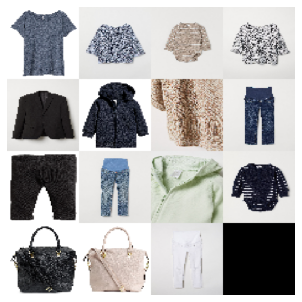

In [ ]:
(DocumentArray(query_doc.matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())).plot_image_sprites()